# Lab 2b Sentiment Analysis

Created by Tomas Nordström, Umeå University

Adapted by Jacob Farnsworth for HT 2025 Programmering för tekniska tillämpningar, NTI Gymnasiet Karlstad

## Write your name here

## Background: Sentiment Analysis

*Sentiment analysis* is a technique in the field of natural language processing which involves analyzing a text and determining the general emotion or opinion that it conveys.

For example, on a dataset with *movie reviews*:

*   "This movie was great, I loved it!" -> **Positive**
*   "Terrible, just awful." -> **Negative**
*   "This movie was too long and I got bored half way through." -> **Negative**

*Positive*, *negative* or *neutral* is a common classification, but other types of classifications are also possible.

In the language of machine learning, sentiment analysis is simply a classification task on text. Different sentiments are represented by different categories, and the model tries to place each text in the most appropriate category.

In this way, sentiment analysis models have some similarities with image classification models that we used previously. Both perform a form of classification, however, sentiment analysis involves text data as input (vectors, from a word embedding) as opposed to images (pixel color data).

In this lab, we will build and test some smaller models to perform sentiment analysis on movie reviews. There are many different ways to build such a model; we will experiment with *recurrent neural networks* (RNNs), as well as a pretrained attention model called BERT.



## Questions

Read the overview about sentiment analysis [here](https://www.sciencedirect.com/topics/social-sciences/sentiment-analysis).

1. What are some areas where opinion mining/sentiment analysis could be applied (aside from movie reviews)?
2. What is the main difference between a generative language model, such as ChatGPT, and a model that performs sentiment analysis? (What does each type of model have for inputs and outputs?)
3.  According to the article, what are some of the key challenges in sentiment analysis? What do sentiment analysis tools tend to struggle with?

### Your Answers Here

*

## Memory and Attention

Vanilla neural networks (aka feed-forward networks) have some serious limitations, especially when it comes to processing language.

For one, feedforward neural networks take a fixed-size tensor as input, and produce a fixed-size tensor as output. If you tried to use a vanilla neural network to process language, this means that your network would only be able to handle a text with exactly N words/tokens.

Another problem is that feedforward networks don't really have any mechanism for *memory* or *attention*. When a human reads a text, each sentence adds more context, one sentence at a time. Without any ability to consider information from different parts of a text, an AI model would be very ineffective.

For example, if you read the sentence:

"He threw it."

You have no idea what he threw. It could be anything. On its own, the sentence doesn't really make any sense.

But if this sentence is actually part of a larger text, such as:

"He had a ball. The ball was red. He threw it."

Then the sentence "He threw it" makes perfect sense: "it" refers to a red ball. In order to understand what "it" is, you have to recall or shift your focus to earlier parts of the text. In this case, the word "ball" in the first sentence, and the word "red" in the second sentence.

This illustrates the problem with a feedforward design: A feedforward network would scan one word or sentence at a time. It would arrive at "He threw it" with no memory or ability to consider past sentences.

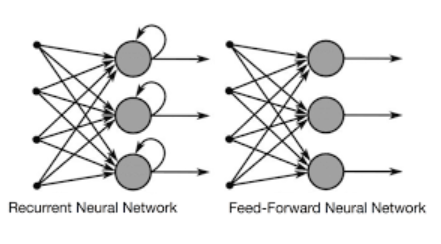

**Recurrent Neural Networks (RNNs)** are a type of neural network in which past outputs are fed back into the network's hidden layers as additional inputs. To put it simply, for an RNN, there are two inputs: the "present" and the "recent past".

RNNs address the issue of memory somewhat, and allow the network to operate on a **sequence of inputs**, rather than just **one input**.

There are different types of RNNs. Some of the most common are:

*   Long Short-Term Memory (LSTM)
*   Gated Recurrent Unit (GRU)

RNNs can be used for a variety of different tasks involving sequences of data (weather forecasting, stock prices) but they have been used successfully in language processing as well.

**Attention** is another approach to language processing which was developed by researchers at Google, and was used in great success in the Transformer model. As of 2025, attention is used in essentially all the large language models, for example ChatGPT.

The original paper, [Attention is All You Need](https://arxiv.org/abs/1706.03762) became somewhat famous in the AI/ML world, since in many ways, it paved the way for the language model boom.

Attention involves some rather complicated mechanisms, but in simple terms, attention involves the model learning to measure the importance of different words in a text. Each word in the text is assigned an **attention score**, which helps the model to "focus" on the most relevant parts, depending on the query.

Here's a simplified example: Given the text from before, when the input token is "it", an attention model might assign attention scores that look something like this:

```
                                                    <>
He  had  a   ball.  The  ball was red.   He threw   it.
0   0   0.1  0.9    0.1  0.9  0.1 0.7    0  0.4     1.0
```

In this example, the model assigns higher attention scores to the words "ball" and "red". In this way, the model is able to "shift focus" around the text, and consider the most relevant parts.

BERT is an example of a model built using attention and the Transformer model.

## Initialize Python environment

In [ ]:
import sys
import os
import time

### Is this notebook running on Colab?
IS_COLAB = "google.colab" in sys.modules

### Is this notebook running on Kaggle?
# Fool Kaggle into making kaggle_secrets avaiable
try:
    import kaggle_secrets
except ImportError as e:
    pass
# Now we can test for Kaggle
IS_KAGGLE = "kaggle_secrets" in sys.modules

In [ ]:
# To avoid a bug we install a newer version of tensorflow and keras
import tensorflow as tf
from IPython.display import display, Javascript
import signal
tfversion = tf.__version__
print('TensorFlow version:', tfversion)
if (IS_COLAB or IS_KAGGLE):
    major, minor, *_ = map(int, tfversion.split('.'))

    if (major, minor) < (2, 19):
        print("TensorFlow version is below 2.19. Upgrading to the latest...")
        !pip install -q --upgrade keras tensorflow tensorflow_text keras-hub
        print("You need to restart the runtime now!")
        sys.exit() # should have been a dialog to restart, but I do not know how

2025-05-01 20:58:45.056162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746125925.066421   26532 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746125925.069598   26532 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746125925.077613   26532 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746125925.077620   26532 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746125925.077621   26532 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0


In [ ]:
# Set up Keras backend
os.environ["KERAS_BACKEND"] = "tensorflow" # Also tensorflow,jax,pytorch for Keras 3.0

# Make TF less noisy
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

# Import Keras/TF libraries
import keras
print('Keras version:', keras.__version__)

import tensorflow as tf
print('TensorFlow version:', tf.__version__)

Keras version: 3.9.2
TensorFlow version: 2.19.0


In [ ]:
# Test for GPU and determine what GPU we have
import platform
import subprocess
gpu_devices = tf.config.list_physical_devices('GPU')

gpu_name = tf.test.gpu_device_name()
if gpu_name != '':
    print('TF-GPU-devname:',tf.test.gpu_device_name())
    sys_details = tf.sysconfig.get_build_info()
    physical_devices = tf.config.list_physical_devices('GPU')
    print("Num GPUs:", len(physical_devices))
    if platform.system() == "Darwin":
        print('GPU on Mac!')
    else:
        cuda_version = sys_details["cuda_version"]
        print('TF-cuda version:',cuda_version)
        if len(physical_devices)>0:
            process = subprocess.Popen(['nvidia-smi','-L'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            print(process.communicate())
        # If possible to run code with 16 bits float instead of 32 bits float, this code activates such functionality:
        if gpu_devices:
            details = tf.config.experimental.get_device_details(gpu_devices[0])
            compute_capability=details.get('compute_capability')
            print("Compute capability:",compute_capability)
            if compute_capability[0]>6:
                print("Turning on mixed_float16")
                policy = keras.mixed_precision.Policy('mixed_float16')
                keras.mixed_precision.set_global_policy(policy)
else:
    print('TF-device CPU')

TF-GPU-devname: /device:GPU:0
Num GPUs: 1
TF-cuda version: 12.5.1


2025-05-01 20:58:47.176833: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1746125927.177946   26532 gpu_device.cc:2019] Created device /device:GPU:0 with 22133 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1746125927.183947   26532 gpu_device.cc:2019] Created device /device:GPU:0 with 22133 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


(b'GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-56d64c0c-e161-9720-5e6d-9848f27424d1)\n', b'')
Compute capability: (8, 6)
Turning on mixed_float16


In [ ]:
# Helper libraries
import numpy as np
import pandas as pd

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt

## Read in the data

The IMDb dataset consists of 50,000 movie reviews in English
(25,000 for training, 25,000 for testing) extracted from the famous Internet Movie Database, along with a simple binary target for each review indicating whether it is negative (0) or positive (1).

There are many alternatives to get the data:
* Use the Keras built in [IMDB database](https://keras.io/api/datasets/imdb/) from keras.
* Use the TensorFlow Datasets library for [IMDB reviews](https://www.tensorflow.org/datasets/catalog/imdb_reviews)
* Or as we are going to do, read the [orginal dataset](http://ai.stanford.edu/~amaas/data/sentiment/)

We use to orginal data to see how one can read data (text) files from directories directly. How one can do preprocessing on datasets. The raw data is also preferred when we later want to work with BERT as a transfer learning model. (The Keras data have already preprocessed words into integers.)

In [ ]:
# Reading the database from the source
# following https://keras.io/guides/keras_hub/getting_started/
if not os.path.exists('./aclImdb_v1.tar.gz'):
  !curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
  !tar -xf aclImdb_v1.tar.gz
  !# Remove unsupervised examples
  !rm -r aclImdb/train/unsup

print(os.listdir("./aclImdb"))
print(os.listdir("./aclImdb/train"))
print(os.listdir("./aclImdb/test"))

with open("./aclImdb/train/pos/4242_9.txt") as f:
  print (f'Example of a postive review: {f.read()}')

['train', 'imdb.vocab', 'README', 'test', 'imdbEr.txt']
['unsupBow.feat', 'urls_neg.txt', 'pos', 'neg', 'urls_pos.txt', 'urls_unsup.txt', 'labeledBow.feat']
['urls_neg.txt', 'pos', 'neg', 'urls_pos.txt', 'labeledBow.feat']
Example of a postive review: I read the book and saw the movie. Both excellent. The movie is diamond among coals during this era. Liebman and Selby dominate the screen and communicate the intensity of their characters without flaw. This film should have made them stars. Shame on the studio for not putting everything they had behind this film. It could have easily been a franchise. Release on DVD is a must and a worthy remake would revive this film. Look for it in your TV guide and if you see it listed, no matter how late, watch it. You won't be disappointed. Do yourself another favor - read the book (same title). It'll blow you away. Times have changed dramatically since those days, or at least we like to think they have.


In [ ]:
batch_size = 32

# Load directories of text into our datasets using https://keras.io/api/data_loading/text/
raw_imdb_train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
)
raw_imdb_val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
)
raw_imdb_test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

print(f"Number of batches in raw_imdb_train_ds: {raw_imdb_train_ds.cardinality()}")
print(f"Number of batches in raw_imdb_val_ds: {raw_imdb_val_ds.cardinality()}")
print(f"Number of batches in raw_imdb_test_ds: {raw_imdb_test_ds.cardinality()}")

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


I0000 00:00:1746125927.650910   26532 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22133 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Number of batches in raw_imdb_train_ds: 625
Number of batches in raw_imdb_val_ds: 157
Number of batches in raw_imdb_test_ds: 782


In [ ]:
# Let's print a few samples.
for text_batch, label_batch in raw_imdb_train_ds.take(1):
    for i in range(3):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b'I\'ve seen tons of science fiction from the 70s; some horrendously bad, and others thought provoking and truly frightening. Soylent Green fits into the latter category. Yes, at times it\'s a little campy, and yes, the furniture is good for a giggle or two, but some of the film seems awfully prescient. Here we have a film, 9 years before Blade Runner, that dares to imagine the future as somthing dark, scary, and nihilistic. Both Charlton Heston and Edward G. Robinson fare far better in this than The Ten Commandments, and Robinson\'s assisted-suicide scene is creepily prescient of Kevorkian and his ilk. Some of the attitudes are dated (can you imagine a filmmaker getting away with the "women as furniture" concept in our oh-so-politically-correct-90s?), but it\'s rare to find a film from the Me Decade that actually can make you think. This is one I\'d love to see on the big screen, because even in a widescreen presentation, I don\'t think the overall scope of this film would receive its

2025-05-01 20:58:49.218582: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Note that the raw text contains HTML break tags of the form "\<br /\>"!

We want to remove them later on.

In [ ]:
# The test sentences in this exercise
test_sentences = [
  "That movie was absolutely awful",
  "The acting was a bit lacking",
  "The film was creative and surprising",
  "Absolutely fantastic!",
  "This movie is not worth the money",
  "The only positive thing with this movie is the music"
]

## Data preprocessing

In [ ]:
# Model constants
vocab_size = 10000
sequence_length = 100

### Setup

In [ ]:
# We will now convert the text to lowercase and remove html stuff
# Based on https://keras.io/examples/nlp/text_classification_from_scratch/

import string
import re

# Having looked at our data above, we see that the raw text contains HTML break
# tags of the form '<br />'. These tags will not be removed by the default
# standardizer (which doesn't strip HTML). Because of this, we will need to
# create a custom standardization function.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )

# Now that we have our custom standardization, we can instantiate our text
# vectorization layer. We are using this layer to normalize, split, and map
# strings to integers, so we set our 'output_mode' to 'int'.
# Note that we're using the default split function,
# and the custom standardization defined above.
# We also set an explicit maximum sequence length, since the CNNs later in our
# model won't support ragged sequences.
preprocessing_layer = keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Now that the vocab layer has been created, call `adapt` on a text-only
# dataset to create the vocabulary. You don't have to batch, but for very large
# datasets this means you're not keeping spare copies of the dataset in memory.

# Let's make a text-only dataset (no labels):
text_ds = raw_imdb_train_ds.map(lambda x, y: x)
# Let's call `adapt` (to initialise the vocabulary on the text from the training set)
preprocessing_layer.adapt(text_ds)

# Define a function to prepare the text in a dataset (batch)
def preprocessing_text(text, label):
    text = tf.expand_dims(text, -1)
    return preprocessing_layer(text), label

2025-05-01 20:58:51.638412: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# Get the vocabulary
voc = preprocessing_layer.get_vocabulary()
print(voc[:8])
word_index = dict(zip(voc, range(len(voc))))

['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('a'), np.str_('of'), np.str_('to'), np.str_('is')]


In [ ]:
# preprocessing the data.
train_ds = raw_imdb_train_ds.map(preprocessing_text)
val_ds = raw_imdb_val_ds.map(preprocessing_text)
test_ds = raw_imdb_test_ds.map(preprocessing_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

## Using recurrent neural networks (RNN) for text

This corresponds to Geron's Chapter 16 - Natural Language Processing with RNNs and Attention, and [the corresponding code](https://github.com/ageron/handson-ml3/blob/main/16_nlp_with_rnns_and_attention.ipynb).

We are here only working on word level (not character level as in the beginning of Chapter 16)

### The Embedding Layer

The [Embedding](https://keras.io/api/layers/core_layers/embedding/) Layer turns positive integers (indexes) into dense vectors of fixed size.

Here each input integer corresponds to a word in our vocabulary (typical size between 1000 and 30000), and is mapped into a short and dense vector (typical size 32-512). In a similar way as the word2vec mapping in the first part of this exercise. However, this mapping is initialized as a random mapping for each model, that then is adjusted during training.

In [ ]:
embedding_dim = 32

from keras.layers import Embedding

### The SimpleRNN Layer.

The [SimpleRNN](https://keras.io/api/layers/recurrent_layers/simple_rnn/) is a fully-connected RNN where the output is to be fed back as the new input. It processes batches of sequences, that is, it takes inputs of shape `(batch_size, timesteps, input_features)`.

Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes: it can return either the full sequences of successive
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each
input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor
argument. Let's take a look at some examples:

In [ ]:
from keras.layers import SimpleRNN

In [ ]:
input_shape = (sequence_length,) # input_tokens_ex.shape #

In [ ]:
model = keras.models.Sequential()
model.add(keras.Input(shape=input_shape))
model.add(keras.layers.Embedding(vocab_size, embedding_dim))
model.add(keras.layers.SimpleRNN(32)) ## return_sequences=False (is default)
model.add(keras.layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,113 (1.23 MB)

 Trainable params: 322,113 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model = keras.models.Sequential()
model.add(keras.Input(shape=input_shape))
model.add(keras.layers.Embedding(vocab_size, embedding_dim))
model.add(keras.layers.SimpleRNN(32, return_sequences=True))
model.add(keras.layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100, 1)         │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,113 (1.23 MB)

 Trainable params: 322,113 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network.
In such a setup, you have to get all intermediate layers to return full sequences:

In [ ]:
model = keras.models.Sequential()
model.add(keras.Input(shape=input_shape))
model.add(keras.layers.Embedding(vocab_size, embedding_dim))
model.add(keras.layers.SimpleRNN(32, return_sequences=True))
model.add(keras.layers.SimpleRNN(32, return_sequences=True))
model.add(keras.layers.SimpleRNN(32, return_sequences=True))
model.add(keras.layers.SimpleRNN(32))  # This last layer only returns the last outputs.
model.add(keras.layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 100, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 100, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 100, 32)        │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,353 (1.25 MB)

 Trainable params: 328,353 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

## Test of SimpleRNN
Here we want to understand the influence of sequence_length and masking

### Helper function to compile and train a model

In [ ]:
def compile_and_fit(model, epochs=10, patience=3, verbose=1):
  print(f'Training {model.name}')
  model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=5e-4),
                loss='binary_crossentropy',
                metrics=['acc'],
                jit_compile=True,)

  early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience,restore_best_weights = True)

  start = time.time()
  history = model.fit(train_ds,
                      epochs=epochs,
                      validation_data=val_ds,
                      verbose = verbose,
                      callbacks=[early_stopping])
  end = time.time()
  print(f"Time to run: {end - start:.1f}",)
  return model, history

### Now train your first RNN model for sentiment analysis

Let's train a simple recurrent network using an `Embedding` layer and a single `SimpleRNN` layer:

In [ ]:
model = keras.Sequential([
    # Set up input shape
    keras.Input(shape=(None,), dtype="int32"),
    # Next, we add a layer to map those vocab indices into a space of dimensionality 'embedding_dim'.
    keras.layers.Embedding(vocab_size, embedding_dim),
    # Our RNN model
    keras.layers.SimpleRNN(32),
    # End part for classification
    keras.layers.Dense(1,activation='sigmoid')
],name='SimpleRNN32')

In [ ]:
model,history = compile_and_fit(model, patience=2)

Training SimpleRNN32
Epoch 1/10


I0000 00:00:1746125933.125517   26680 service.cc:152] XLA service 0x5ff4d28acb80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746125933.125528   26680 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-05-01 20:58:53.157469: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746125933.322938   26680 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746125935.867942   26680 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - acc: 0.6023 - loss: 0.6554 - val_acc: 0.7990 - val_loss: 0.4774
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 0.8081 - loss: 0.4404 - val_acc: 0.8034 - val_loss: 0.4346
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 0.8530 - loss: 0.3530 - val_acc: 0.7984 - val_loss: 0.4374
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 0.8843 - loss: 0.2911 - val_acc: 0.7930 - val_loss: 0.4504
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.
Time to run: 20.1


In [ ]:
test_loss, test_acc =  model.evaluate(test_ds, verbose=0)
print(f'Model {model.name}, len={sequence_length}, test accuracy: {test_acc:.3f}')

Model SimpleRNN32, len=100, test accuracy: 0.794


Unfortunately, our small SimpleRNN network does not perform very well. Part of the problem is that our inputs only consider the first 100/500 words rather the full sequences. The rest of the problem is simply that SimpleRNN is not very good at processing long sequences, like text. Other types of RNNs perform much better. Let's take a look at some more advanced layers.

In [ ]:
model.summary()

Model: "SimpleRNN32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, None, 32)       │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 644,232 (2.46 MB)

 Trainable params: 322,113 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 322,119 (1.23 MB)

Let's display the training and validation loss and accuracy:

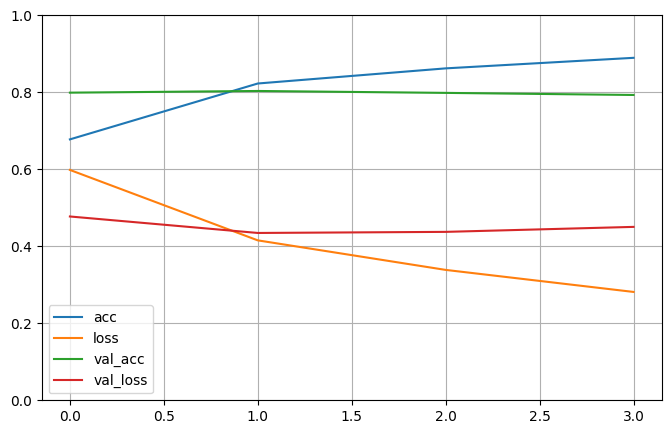

In [ ]:
# Plot training history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

## ‽ Frågor
Undersök hur Sekvenslängd och Mask påverkar prestandan
* Notera vilken testnoggrannhet du får för detta fall (sequence_length=100)
* Gå nu upp och ändra sequence_length till 500, vilken testnoggrannhet får du då? Vad kan vara skälet till detta beteende?
* Pröva sedan med att sätta 'mask_zero=True' i Embedding-lagret
* Kompletera sedan bilden med att köra med 'mask_zero=True' och sequence_length=100

Dvs du ska göra fyra körningar sequence_length=\{100,500\} och mask_zero=\{True, False\}. Redovisa gärna som en tabell.

Titta även på träningskurvorna, går det fort för modellen att överträna? Vad händer om du halverar learning_rate (med träningstid, testnoggrannhet, träningskurvorna)?

### STUDENTSVAR (FRÅGOR):
*
*

## Ett LSTM-exempel i Keras

Låt oss nu gå vidare till en mer kraftfull RNN-modell: en modell med ett LSTM-lager och sedan träna det på våra IMDB-data. Här kommer vår LSTM-modell att
likna det med `SimpleRNN` som vi just presenterade. Vi specificerar bara LSTM-lagrets utmatningsdimensionalitet och lämnar alla
andra argument (det finns många) till Keras standardvärden. Keras har bra standardvärden, och saker och ting kommer nästan alltid att "bara fungera" utan att du
behöver lägga tid på att justera parametrar manuellt.

In [ ]:
model = keras.Sequential([
    keras.Input(shape=(None,), dtype="int32"),
    keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(1,activation='sigmoid')
],name='LSTM32')

In [ ]:
model.summary()

Model: "LSTM32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, None, 32)       │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,353 (1.25 MB)

 Trainable params: 328,353 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model,history = compile_and_fit(model,patience=2)

Training LSTM32


/home/tono/.venv/lib/python3.11/site-packages/keras/src/trainers/trainer.py:212: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`.
  warnings.warn(


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - acc: 0.5651 - loss: 0.6605 - val_acc: 0.8072 - val_loss: 0.4521
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - acc: 0.8149 - loss: 0.4101 - val_acc: 0.8188 - val_loss: 0.4034
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - acc: 0.8567 - loss: 0.3350 - val_acc: 0.8228 - val_loss: 0.3931
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - acc: 0.8769 - loss: 0.3007 - val_acc: 0.8198 - val_loss: 0.3966
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - acc: 0.8900 - loss: 0.2775 - val_acc: 0.8158 - val_loss: 0.4042
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 3.
Time to run: 16.8


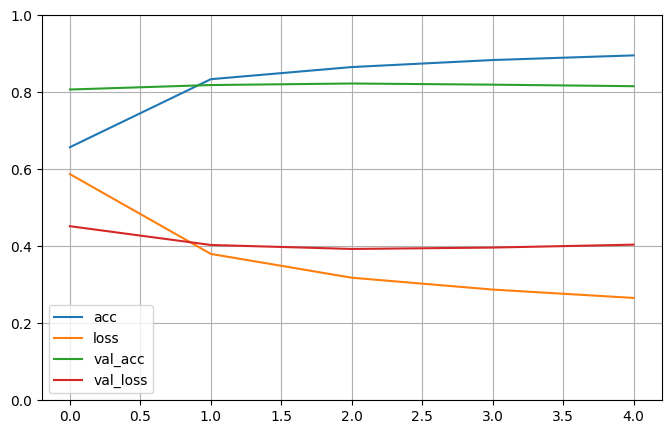

In [ ]:
# Plot training history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
test_loss, test_acc =  model.evaluate(test_ds, verbose=0)
print(f'Model {model.name}, len={sequence_length}, test accuracy: {test_acc:.3f}')

Model LSTM32, len=100, test accuracy: 0.804


Notera att vi nu har mycket bättre resultat och modellen är fortfarande liten.

### Fråga
* Hur många parametrar har LSTM-lagret?
* Hur många har embedding lagret?

### STUDENTSVAR (Frågor):
*
*

## Testing with Test sentences

In [ ]:
# See what the model say about the test sentences
tspred = model.predict(preprocessing_layer(test_sentences))
for ix in range(len(tspred)):
  print(f'{tspred[ix,0]:.2f} -- {test_sentences[ix]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
0.17 -- That movie was absolutely awful
0.47 -- The acting was a bit lacking
0.63 -- The film was creative and surprising
0.67 -- Absolutely fantastic!
0.43 -- This movie is not worth the money
0.37 -- The only positive thing with this movie is the music


### Fråga:
Känns modellens bedömning korrekt?

### STUDENTSVAR (Analys):


# ‽ Uppgift
Utforska fler LSTM modeller (Om du får problem med körtiderna så kan du för denna del använda sekvenslängd 100 och bara för den absolut bästa modellen köra en gång med längd 500 så vi får något att jämföra med i följande delar).
* LSTM(128) med 128 noder, Två lager av LSTM(2L32), en en bidirektionell LSTM BiLSTM(32) och analysera dessa resultat.
* Hitta en "bästa" modell att gå vidare med.
* Undersök ifall det finns någon regularisering som förbättrar testnoggrannheten (notera att det finns speciella regulariseringar för LSTM modeller som du också kan pröva).

* Testa din bästa RNN-modell på våra testmeningar, finns det några meningar som modellen är osäker på, och i så fall, är det förståeligt?


## STUDENTSVAR (Kod):

In [ ]:
# Code where you evaluate all these variants of LSTM models

## STUDENTSVAR (Analys):

# Test a CNN Model
How good would a CNN model be on this problem?

## Set up a CNN model and train

In [ ]:
embedding_dim = 32

In [ ]:
# A integer input for vocab indices.
inputs = keras.Input(shape=(None,), dtype="int32")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = keras.layers.Embedding(vocab_size, embedding_dim)(inputs)
x = keras.layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = keras.layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = keras.layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = keras.Model(inputs, predictions,name='CNN')

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
epochs = 3

# Fit the model using the train and test datasets.
model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6105 - loss: 0.6266 - val_accuracy: 0.8130 - val_loss: 0.4119
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8323 - loss: 0.3806 - val_accuracy: 0.8258 - val_loss: 0.3960
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8826 - loss: 0.2902 - val_accuracy: 0.8206 - val_loss: 0.4294


In [ ]:
test_loss, test_acc =  model.evaluate(test_ds, verbose=0)
print(f'Model {model.name}, len={sequence_length}, test accuracy: {test_acc:.3f}')

Model CNN, len=100, test accuracy: 0.799


In [ ]:
# See what the model say about the test sentences
tspred = model.predict(preprocessing_layer(test_sentences))
for ix in range(len(tspred)):
  print(f'{tspred[ix,0]:.2f} -- {test_sentences[ix]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
0.07 -- That movie was absolutely awful
0.52 -- The acting was a bit lacking
0.76 -- The film was creative and surprising
0.76 -- Absolutely fantastic!
0.33 -- This movie is not worth the money
0.58 -- The only positive thing with this movie is the music


## Analys
* Jämför din (bästa) LSTM-modell med denna CNN-modell, vilka slutsatser drar du?

## STUDENTSVAR (Analys):

# Now testing with BERT using Keras NLP
https://keras.io/guides/keras_hub/getting_started/

In [ ]:
import keras_hub
print('Keras Hub version:', keras_hub.__version__)

# Read all the possible parts for a pretrained model
# https://keras.io/api/keras_hub/models/

model_name = "bert_small_en_uncased"
#model_name = "bert_tiny_en_uncased"

print(f'Using {model_name}')
classifier   = keras_hub.models.BertClassifier.from_preset(model_name, num_classes=2)
backbone     = keras_hub.models.BertBackbone.from_preset(model_name)
tokenizer    = keras_hub.models.BertTokenizer.from_preset(model_name)
preprocessor = keras_hub.models.BertPreprocessor.from_preset(model_name)

Keras Hub version: 0.20.0
Using bert_small_en_uncased


## Read data into datasets

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Use the raw datasets as BERT has its own preprocessing and tokenizer
# Had ".prefetch(buffer_size=AUTOTUNE)" before but this missbehaves on my local GPU
imdb_train = raw_imdb_train_ds.cache()
imdb_val   = raw_imdb_val_ds.cache()
imdb_test  = raw_imdb_test_ds.cache()

In [ ]:
# Inspect first review
# Format is (review text tensor, label tensor)
print(imdb_train.unbatch().take(1).get_single_element())

2025-05-01 21:12:13.786558: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(<tf.Tensor: shape=(), dtype=string, numpy=b'While Fred Schepisi\'s "I.Q." doesn\'t really have any important qualities, it\'s still worth seeing. Walter Matthau plays Albert Einstein, trying to help mechanic Ed Walters (Tim Robbins) fall in love with Princeton mathematics doctoral candidate Catherine Boyd (Meg Ryan). Probably the funniest scene is when Dr. Frizzyhead and friends (Lou Jacobi, Gene Saks and Joseph Maher) try to make Ed look like a scientist: he ends up looking like a French impressionist.<br /><br />Obviously little of the movie is historically accurate, but that\'s not the point. It\'s not intended as anything except a light comedy, quite the opposite of Robbins\'s most famous movie from 1994 (The Shawshank Redemption). A movie about Einstein\'s whole life would have to focus not only on his scientific achievements, but also his political activism, namely how he wrote a letter on behalf of the Scottsboro Nine and came out against nuclear weapons (it got to the point wh

## Use the BERT classifier  (contains both preprocessor and backbone)

https://keras.io/api/keras_hub/models/bert/bert_classifier/

In [ ]:
classifier   = keras_hub.models.BertClassifier.from_preset(model_name, num_classes=2)

start = time.time()
classifier.fit(
    imdb_train,
    validation_data=imdb_val,
    epochs=2,
)
end = time.time()
print(f"Time to run: {end - start:.1f}",)
# This take approximately 300s on a T4

Epoch 1/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 66ms/step - loss: 0.4020 - sparse_categorical_accuracy: 0.8050 - val_loss: 0.2453 - val_sparse_categorical_accuracy: 0.9032
Epoch 2/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - loss: 0.1996 - sparse_categorical_accuracy: 0.9237 - val_loss: 0.2509 - val_sparse_categorical_accuracy: 0.9082
Time to run: 96.6


In [ ]:
test_loss, test_acc =  classifier.evaluate(imdb_test, verbose=0)
print(f'Model {classifier.name} test accuracy: {test_acc:.3f}')

Model bert_text_classifier_5 test accuracy: 0.910


In [ ]:
tspred = classifier.predict(test_sentences, verbose=0)
for ix in range(len(tspred)):
  sm =keras.activations.softmax(tspred[ix])
  print(f'{sm[1]:.2f} -- {test_sentences[ix]}')

0.01 -- That movie was absolutely awful
0.08 -- The acting was a bit lacking
0.88 -- The film was creative and surprising
0.99 -- Absolutely fantastic!
0.06 -- This movie is not worth the money
0.42 -- The only positive thing with this movie is the music


In [ ]:
classifier.summary()

Preprocessor: "bert_text_classifier_preprocessor_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                                │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "bert_text_classifier_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 512), (None,      │      28,763,648 │ padding_mask[0][0],        │
│                               │ None, 512)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 512)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,026 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 86,294,028 (329.19 MB)

 Trainable params: 28,764,674 (109.73 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 57,529,354 (219.46 MB)

# ‽ Uppgift
* Jämför dina tidigare modeller mot denna BERT. Vilka slutsatser drar du?

## STUDENTSVAR (Analys):

# VG uppgifter

### För BERT
Istället för att använda den färdiga BertClassfier så ska du här använda BERTBackbone med överförd inlärning. Nedan ger jag ett exempel. Om det blir för långa körtider kan du byta modell till "bert_tiny_en_uncased"
* Din uppgift är att undersök om du kan hitta några egna "top" lager som förbättrar denna BERT-modell.

In [ ]:
# Put a stop here so that only those that want to do VG will remove this and continue running
sys.exit()

SystemExit: 

# Now work with BERT model backbone more directly
Based on
https://keras.io/guides/keras_hub/getting_started/

In [ ]:
# If we only use the backbone, we need to preprocess our data
imdb_train_preprocessed = (
    imdb_train.map(preprocessor, tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
)
imdb_val_preprocessed = (
    imdb_val.map(preprocessor, tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
)
imdb_test_preprocessed = (
    imdb_test.map(preprocessor, tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
)

In [ ]:
def bert_compile_and_fit(model, epochs=15, patience=2):
  model.compile(
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer=keras.optimizers.AdamW(5e-5),
      metrics=[keras.metrics.SparseCategoricalAccuracy()],
      jit_compile=True,
  )

  early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                                verbose=1, patience=patience,
                                                restore_best_weights = True)

  start = time.time()
  history = model.fit(
      imdb_train_preprocessed,
      validation_data=imdb_val_preprocessed,
      epochs=epochs,
      callbacks=[early_stopping]
  )
  end = time.time()
  print(f"Time to run: {end - start:.1f}",)
  return model,history

## Only train top (everything after backbone)

## STUDENTSVAR VG (Kod)
Din uppgift är att undersöka om du kan hitta några egna "top" lager som förbättrar denna BERT-modell.

In [ ]:
# Now Do Not train backbone
backbone.trainable = False

# Set up model using transfer learning of backbone
inputs = backbone.input
# There are multiple parts as output from backbone, but this was difficult to figure out before
# the example in https://keras.io/guides/keras_hub/getting_started/
sequence = backbone(inputs)["sequence_output"]
for _ in range(2):
    sequence = keras_hub.layers.TransformerEncoder(
        num_heads=2,
        intermediate_dim=512,
        dropout=0.1,
    )(sequence)

# Note that if you want your own layers here then its input should be (sequence[:, backbone.cls_token_index, :])
x = keras.layers.Dense(2)(sequence[:, backbone.cls_token_index, :])

model = keras.Model(inputs=inputs, outputs=x, name = f'{model_name}-basic_backbone-only_top_train')
model.summary()

Model: "bert_small_en_uncased-basic_backbone-only_top_train"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 512),     │ 28,763,648 │ padding_mask[0][… │
│ (BertBackbone)      │ (None, None,      │            │ segment_ids[0][0… │
│                     │ 512)]             │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encoder │ (None, None, 512) │  1,577,984 │ bert_backbone[0]… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 512) │  1,577,984 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 512)       │          0 │ transformer_enco… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 2)         │      1,026 │ get_item_7[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,920,642 (121.77 MB)

 Trainable params: 3,156,994 (12.04 MB)

 Non-trainable params: 28,763,648 (109.72 MB)

In [ ]:
model,history = bert_compile_and_fit(model)
# Takes approximately 1560s (ES on epoch 6) on a T4

Epoch 1/15


2025-05-01 21:15:26.211711: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_29', 8 bytes spill stores, 8 bytes spill loads

2025-05-01 21:15:26.400863: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_72', 204 bytes spill stores, 312 bytes spill loads

2025-05-01 21:15:26.498009: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_72', 4 bytes spill stores, 4 bytes spill loads

2025-05-01 21:15:26.926907: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_29', 164 bytes spill stores, 164 bytes spill loads

2025-05-01 21:15:27.136001: I external/local_xla

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5169 - sparse_categorical_accuracy: 0.7432

2025-05-01 21:15:59.626976: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25', 380 bytes spill stores, 380 bytes spill loads

2025-05-01 21:16:00.268279: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25', 16 bytes spill stores, 16 bytes spill loads

2025-05-01 21:16:00.329660: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_27', 380 bytes spill stores, 380 bytes spill loads

2025-05-01 21:16:00.638212: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_51', 228 bytes spill stores, 708 bytes spill loads

2025-05-01 21:16:00.820724: I external/loc

625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - loss: 0.5167 - sparse_categorical_accuracy: 0.7433 - val_loss: 0.3247 - val_sparse_categorical_accuracy: 0.8580
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 0.3301 - sparse_categorical_accuracy: 0.8577 - val_loss: 0.3033 - val_sparse_categorical_accuracy: 0.8704
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 0.3003 - sparse_categorical_accuracy: 0.8785 - val_loss: 0.3033 - val_sparse_categorical_accuracy: 0.8740
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 0.2880 - sparse_categorical_accuracy: 0.8817 - val_loss: 0.2892 - val_sparse_categorical_accuracy: 0.8806
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 0.2761 - sparse_categorical_accuracy: 0.8873 - val_loss: 0.3054 - val_sparse_categorical_accuracy: 0.8740
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 0.2588 - sparse_categorical_accuracy: 0.8968 - val_loss: 0.2976 - val_sparse_categorical_accuracy: 0.8798
Epo

In [ ]:
test_loss, test_acc =  model.evaluate(imdb_test_preprocessed, verbose=0)
print(f'Model {model.name} test accuracy: {test_acc:.3f}')

Model bert_small_en_uncased-basic_backbone-only_top_train test accuracy: 0.888


In [ ]:
# See what the model say about the test sentences
tspred = model.predict(preprocessor(test_sentences), verbose=0)
for ix in range(len(tspred)):
  sm =keras.activations.softmax(tspred[ix])
  print(f'{sm[1]:.2f} -- {test_sentences[ix]}')

2025-05-01 21:18:19.568647: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_62', 4 bytes spill stores, 4 bytes spill loads

2025-05-01 21:18:19.823255: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_62_0', 160 bytes spill stores, 160 bytes spill loads

2025-05-01 21:18:20.873107: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_27_0', 356 bytes spill stores, 356 bytes spill loads

2025-05-01 21:18:21.020733: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_27_0', 28 bytes spill stores, 28 bytes spill loads

2025-05-01 21:18:21.268642: I external/l

0.04 -- That movie was absolutely awful
0.02 -- The acting was a bit lacking
0.97 -- The film was creative and surprising
0.98 -- Absolutely fantastic!
0.28 -- This movie is not worth the money
0.18 -- The only positive thing with this movie is the music


## STUDENTSVAR (Analys):


# AI Deklaration
Användning av Al-verktyg är tillåtet i begränsad utsträckning. Du får inte klistra in uppgifter eller delar av uppgifter, men du får använda AI för att förtydliga nya ord och begrepp eller ge exempel.

Här på slutet ska du ange allmänt vilka AI-verktyg som använts, hur du använt dem, och hur användbara dessa verktyg är. Om du inte använt AI-stöd så skriv bara att "AI-verktyg har ej använts".

### STUDENTSVAR (AI-användning):